<a href="https://colab.research.google.com/github/soni113/Deployment-flask/blob/master/PUBG_Game_Webinar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/aZbfX73.png)


In [2]:
!wget "https://www.dropbox.com/s/zobiwi4otsz5768/test_V2.csv.zip"
!wget "https://www.dropbox.com/s/25fcgnykp70yvl6/train_V2.csv.zip"

--2021-10-23 14:29:29--  https://www.dropbox.com/s/zobiwi4otsz5768/test_V2.csv.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zobiwi4otsz5768/test_V2.csv.zip [following]
--2021-10-23 14:29:29--  https://www.dropbox.com/s/raw/zobiwi4otsz5768/test_V2.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc398f56ce5789e7b94ece5c39f0.dl.dropboxusercontent.com/cd/0/inline/BYkRMFfZZ_nAPaoCr2ghnnxvFjhXVgLlE8szqe8_t-4HpRCh9l-qj-FrFSfU_xnhZr08h-baLQalmHhqNE-hOyekWgL-q6ebFktXixXxbTVIU9H1T_Ywi_OLI565jT-zI9CZfh84eflbTNlw4ReToKLu/file# [following]
--2021-10-23 14:29:29--  https://uc398f56ce5789e7b94ece5c39f0.dl.dropboxusercontent.com/cd/0/inline/BYkRMFfZZ_nAPaoCr2ghnnxvFjhXVgLlE8szqe8_t-4HpRCh9l-qj-FrFSfU_xnhZr08h-baLQalmHhqN

In [3]:
!unzip test_V2.csv.zip
!unzip train_V2.csv.zip
!rm /content/train_V2.csv.zip
!rm /content/test_V2.csv.zip

Archive:  test_V2.csv.zip
  inflating: test_V2.csv             
Archive:  train_V2.csv.zip
  inflating: train_V2.csv            


#PUBG: Battle Royale - Finish Placement Prediction

**Problem Statement:**

In a PUBG game, up to 100 players start in each match (**matchId**). Players (**Id**) can be on teams (**groupId**) which get ranked at the end of the game (**winPlacePerc**) based on how many other teams are still alive when they are eliminated. During the game, players can pick up different amunitions, revive downed-but-not-dead (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

The team at [PUBG](https://www.pubg.com/) has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This workshop is not an official or affiliated PUBG site. Its based on the data collected by Kaggle and made available through the [PUBG Developer API](https://developer.pubg.com/).

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

**Goal:** 

Perform the PUBG data analysis and answer the following questions:

- Does killing more people increases the chance of winning the game?
  - **Hint:** Use the correlation between the match winning percentage and number of kills to determine the relationship

- How do we catch the fraudsters in the game?
 - **Hint:** Use various logical conditions based on game knowledge to determine fraudsters in the game

- Can we predict the finishing position of a player in the game?
 - **Hint:** Regression Problem: Train and test a model using regression algorithm to predict the final position of the player at the end of the game. Create a model which **predicts players' finishing placement** based on their final stats, on a scale from 1 (first place) to 0 (last place).




![](https://thumbs.gfycat.com/SlimyInsignificantDolphin-max-1mb.gif)

In [6]:
# Importing the required libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import warnings
warnings.filterwarnings("ignore")

##Loading the Data

###Reduce Memory Usage

The size of the PUBG dataset is pretty big for a lower/mid-range laptop so here's a script to make the dataset smaller without losing information.

It uses the following approach:
- Iterate over every column
- Determine if the column is numeric
- Determine if the column can be represented by an integer
- Find the min and the max value
- Determine and apply the smallest datatype that can fit the range of values

This reduces the dataset from approx. 900 MB to 466 MB

In [8]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

###Loading CSV files to Dataframe

In [9]:
%%time
train = pd.read_csv('/content/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 27.8 s, sys: 4.51 s, total: 32.3 s
Wall time: 32.4 s


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [ ]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


##Dataset Description: Know your data first!

We’ll be using data collected by Kaggle via the [PUBG Developer API](https://developer.pubg.com/). The dataset comprises of 65,000 games worth of anonymised player data, split into training and tests sets. For the purposes of this exploratory analysis we’re only going to be looking at the training data set.

The training set comes in the form of a .CSV file. This file contains 113,290,736 individual data points in 26 columns and 4,357,336 rows.
- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time. 

(**Think:** *Will groupID add any value in our prediction?)*
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.

(**Think:** *Why matchID won't add any value in our prediction?)*
- **assists** - Number of times you helped your friend when he killed an enemy
- **boosts** - Number of boost items used.

**What is it ?** Boost may refer to Energy Drink,Painkillers, Adrenaline Syringe

**About:** The boost bar is a thin white line visible above the health bar. It is cut into 4 sections, which fill up when the player uses a boost item. The first section of the boost bar lasts for 1 minute and will heal 1% health every 8 seconds, for a total of 7% health.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked

**What is it?** Stands for 'Down But No Out'. During Duo or squad play, when you lose all your hit points(HP), you get into this mode. In this mode, your duo or squad members can heal you and that is why we don't count this as an out.
'Revive State' is a feature in BATTLEGROUNDS that can be used to revive downed squad mates. Once your HP reaches 0 you will go into a DBNO state. You can only crawl and drop items, but you cannot shoot or use items while in this state.
- **headshotKills** - Number of enemies you killed with headshots.
- **heals** - Number of healing items used.

(**Think:** *Will heals add any value in predicting finish placement?)*

**About:** There are three basic health items in PUBG: Bandages, First Aid Kits and Med Kits. These all restore your health bar. 
- **killPlace** - Your ranking in match in terms of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Ranking where only winning matters).
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time. A Killstreak is earned when a player acquires a certain number of kills in a row without dying.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times you revived your teammates.
- **rideDistance** - Total distance traveled in vehicles (measured in meters).
- **roadKills** - Number of enemy killed while travelling in a vehicle.
- **swimDistance** - Total distance traveled by swimming (measured in meters).
- **teamKills** - Number of times you are killed your teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot (measured in meters).
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Ranking where only winning matters).
- **winPlacePerc** - The target of prediction **(Target Variable)**. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [ ]:
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


### Outliers Detection and Anomalies
No dataset is ever 100% clean and this PUBG dataset is no different.

Some of the data does not reflect the core gameplay because it is drawn from custom game modes or because it has fraudsters. Some of the characteristics of this anomalous data include the following:

- Many kills without moving
- Many roadkills while driving a very short distance
- Suspiciously high number of kills
- Suspiciously long range kills

We can have a debate on whether to drop this data or not; however, hackers and custom games exist in the test set, so we decided that it is valuable information when training our models.

**Corrupt Data:** Due to issues with the API, there is a bug with the groupID column. When a player leaves a match and rejoins, their groupID is reassigned, which causes the creation of larger groups than a gamemode would allow. A squad match only allows 4 people per team. In other words there should be at most 4 of the same groupID’s per team. But because of the bug, we found examples violating this rule in the data. This creates issues when creating team related features as it makes difficult to distinguish the teams.

**Useless Data:** Some features like matchId is only useful for feature extraction such as for finding total players in a match. Because matchId is a hex identifier string, it is not ordinal and has very high unique value count, so we cannot one hot encode it as a categorical. We also found that matchID has very little predictive performance on its own.

![alt text](https://thumbs.gfycat.com/LavishSereneDrever-size_restricted.gif)

##Tasks to be performed:

**Part 1: Exploratory Data Analysis**
 
**Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters**

**Part 3: Feature Engineering**

**Part 4: Final Predition**

#Part 1: Exploratory Data Analysis

###Unique count of Id, groupId, matchId

In [11]:
for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


### Exploring Different Match Type
PUBG offers 3 different game modes:
- Solo - One can play alone (solo,solo-fpp,normal-solo,normal-solo-fpp)
- Duo - Play with a friend (duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp)
- Squad - Play with 4 friends (squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp)

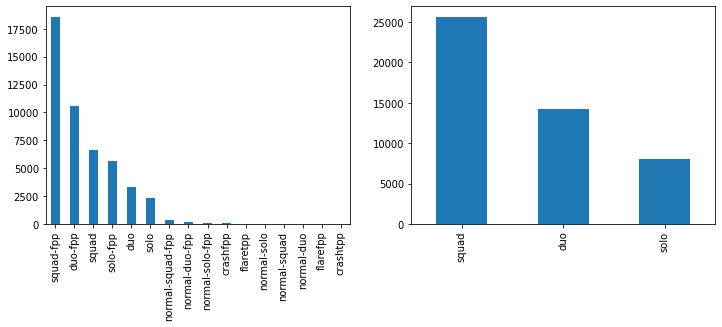

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

###Player Analysis
- players in match and group

During a game, 100 players join the same server,  so in the case of duos the max teams are 50 and in the case of squads the max teams are 25.


In [ ]:
def mergeList(list1,list2):
    return list(itertools.product(list1,list2))
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[mergeList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[mergeList(['players in group'],['min','mean','max'])]], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   1.0  89.031872  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

In [ ]:
group

players in group
matchType matchId        groupId                         
duo       0003b92987589e 024136db14272c                 2
                         058b63035c6c08                 2
                         0c7fbc2742917b                 2
                         1add3b8ce32302                 2
                         1ed2da8e6c07b5                 2
...                                                   ...
squad     fffe92232706aa b671eab579d429                 1
                         bd5b4ecf8067ab                 3
                         c8e95cc6c06d41                 6
                         d57f3a3ed40913                 4
                         d8fa9cfd6f9560                 7

[2026745 rows x 1 columns]

In [ ]:
print(group['players in group'].nlargest(5))

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [ ]:
''' ex) matchId=='3e029737889ce9', groupId=='b8275198faa03b'
'''
subset = train[train['matchId']=='3e029737889ce9']
sub_grp = subset[subset['groupId']=='b8275198faa03b']

print('matchId ==\'3e029737889ce9\' & groupId ==\'b8275198faa03b\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId =='3e029737889ce9' & groupId =='b8275198faa03b'
--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePerc: [0.2449]
--------------------------------------------------
winPlacePerc: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5102 1.    ]


#Check correlation of the feature with Winning Percentage

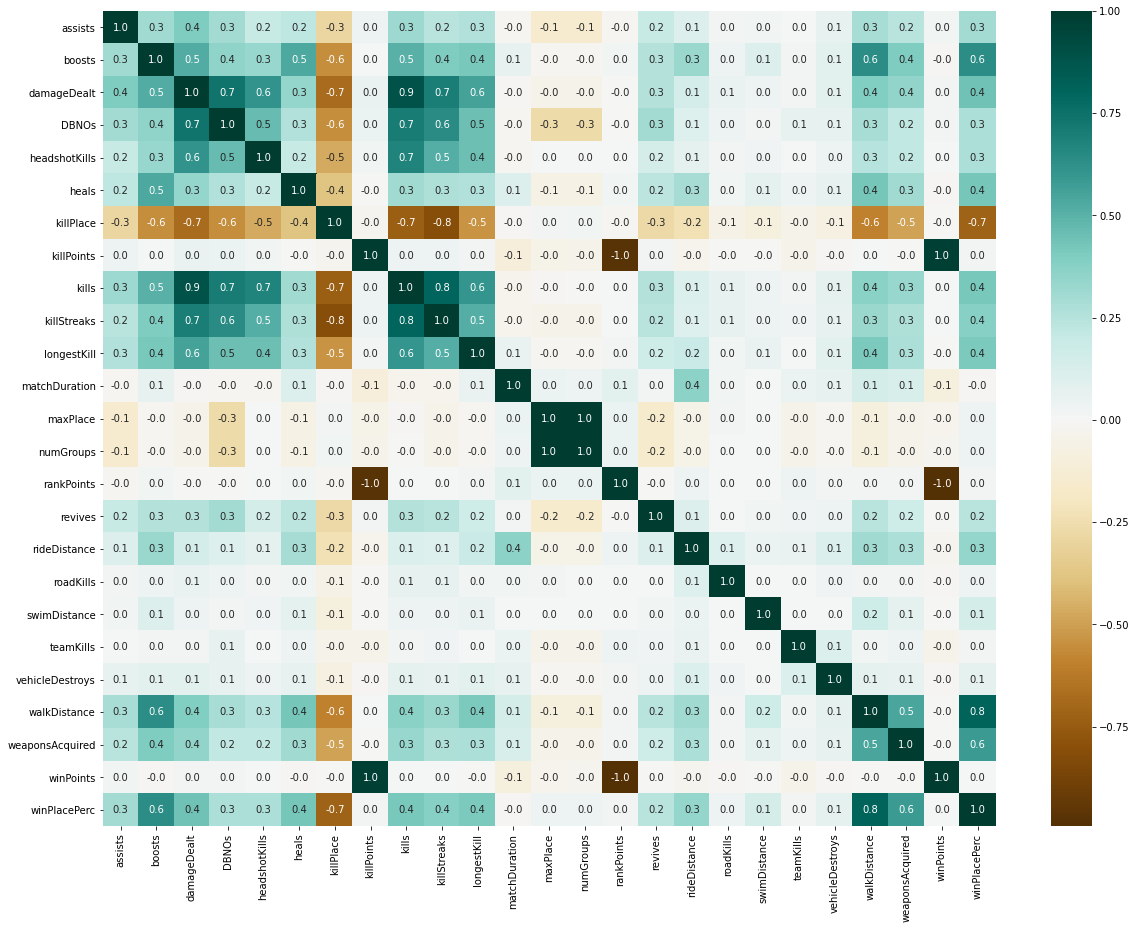

In [ ]:
corr = train.corr()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

# Part 2: Feature Engineering

##Analysing the Kills


![alt text](https://steamuserimages-a.akamaihd.net/ugc/842590018019929617/58725F9B0995477885F13874DF23461A6F47D90F/)

In [ ]:
print("On an average a person kills {:.4f} players, 99% of people have {} kills or less, while the maximum kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

On an average a person kills 0.9248 players, 99% of people have 7.0 kills or less, while the maximum kills ever recorded is 72.


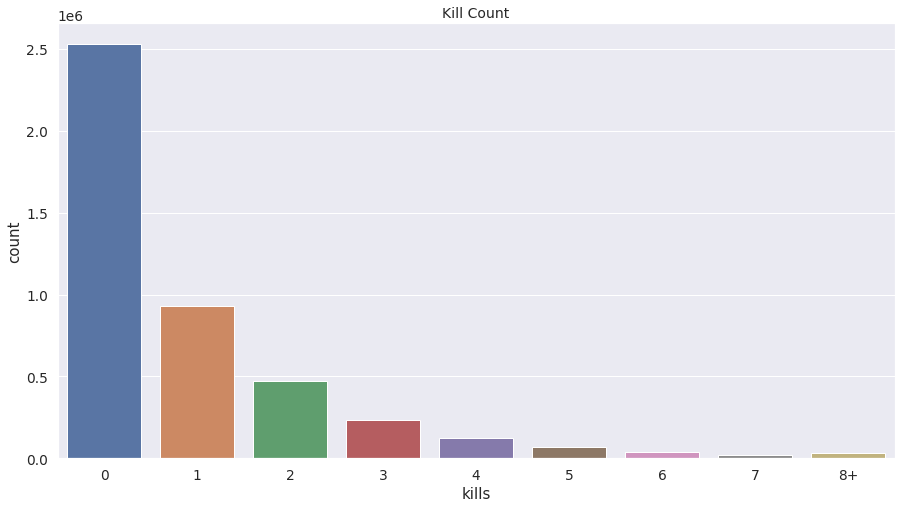

In [ ]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=14)
plt.show()

It seems most of the people cannot even make a single kill. But atleast they deal with some damage

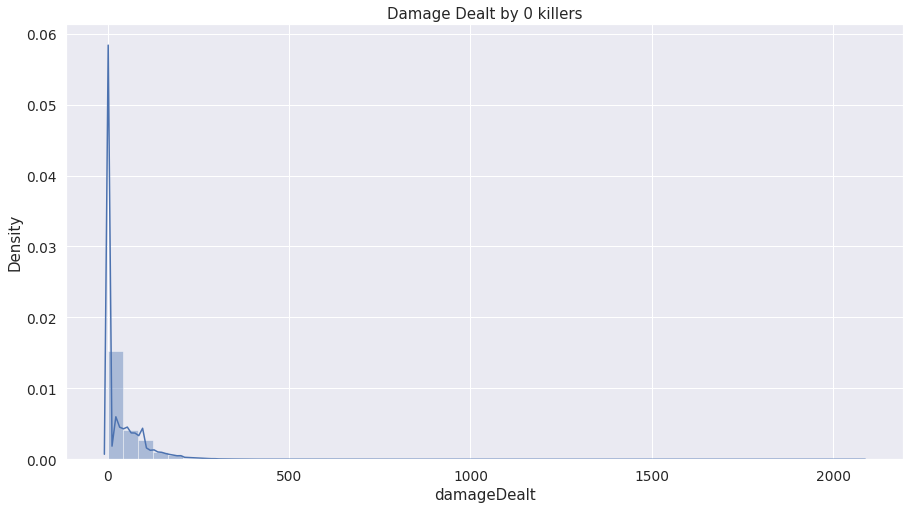

In [ ]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

Well there are few people who win without even making a single kill or dealing with damage.


In [ ]:
print("A total of {} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

A total of 16666 players (0.3748%) have won without a single kill!
A total of 4770 players (0.1073%) have won without dealing damage!


###Effect of Kiiling on Winning percentage

As shown below by the increasing mean of win percentage placement, we found that kill count was correlated with our target variable, which makes sense because **more kills usually means a player is better skilled and will rank closer to the top**.

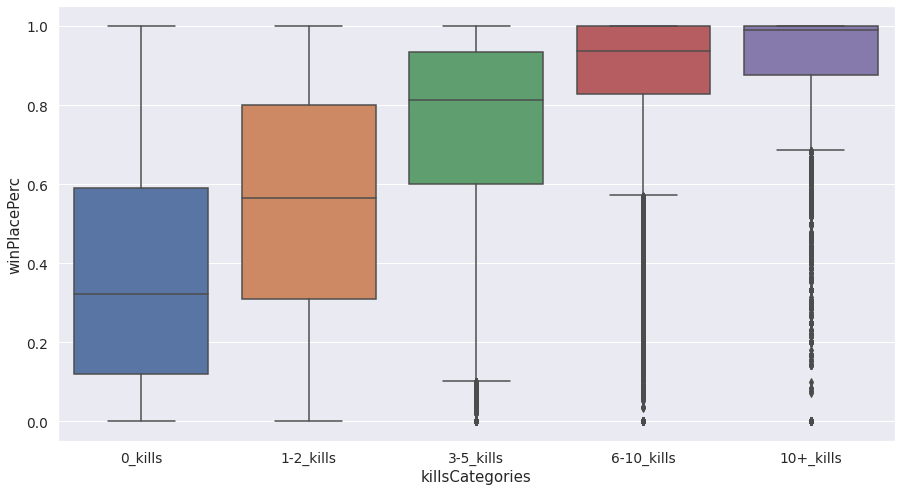

In [ ]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

**Inference:** *kills* has a high correlation with *winPlacePerc*.

## Analysing Running

![alt text](https://cdn.dribbble.com/users/1373613/screenshots/5419266/______-__.gif)

In [ ]:
print("{} players ({:.4f}%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

98054 players (2.0329%) walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


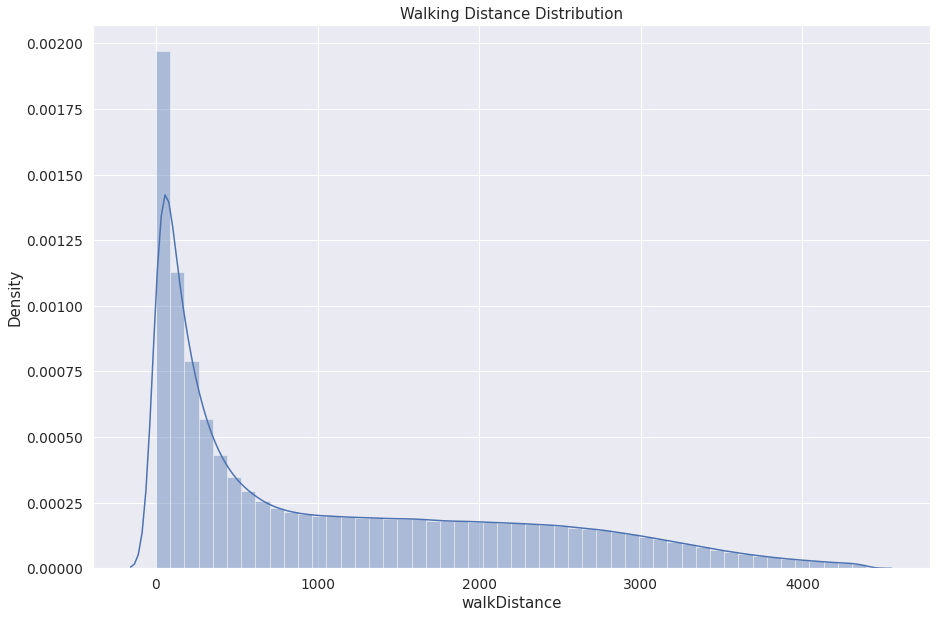

In [ ]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

### Analysing Running: Effect of Running on Winning Percentage


The scatter plot below indicates there is a high correlation between running and winning percentage. This isn’t something new since the **longer you’re alive, the more you run and more is the chance of winning**.

###jointplot
A *marginal plot* or *joint plot* allows to study the relationship between 2 numeric variables. The central chart display their correlation. It is usually a scatterplot, a hexbin plot, a 2D histogram or a 2D density plot. The marginal charts, usually at the top and at the right, show the distribution of the 2 variables using histogram or density plot.

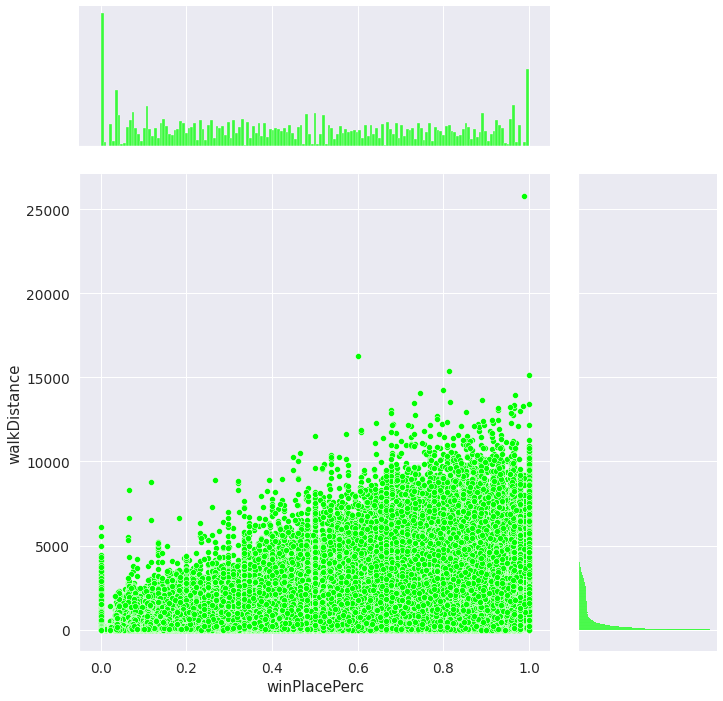

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="lime")
plt.show()

**Inference:** *Walking* has a high correlation with *winPlacePerc*.

## Analysing Riding

In [ ]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE RIDER rode for 40710.0m.


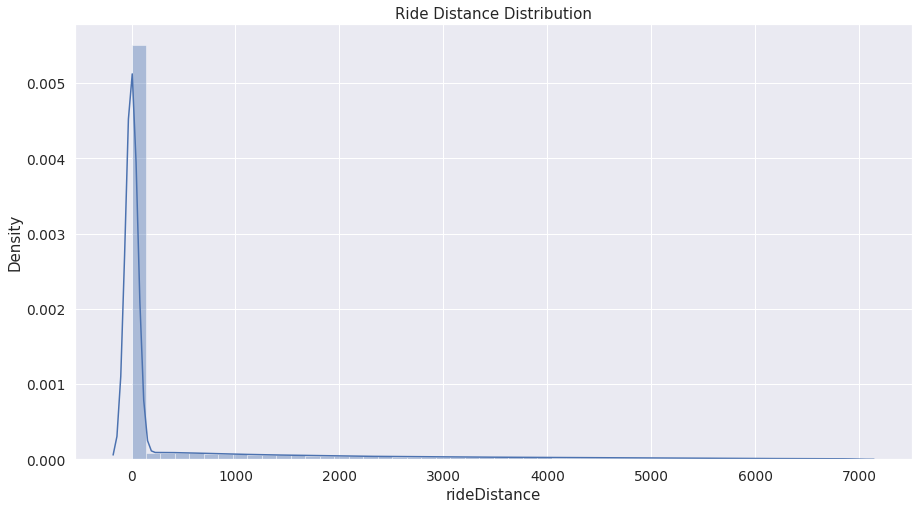

In [ ]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [ ]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they like trekking more than riding.


## Analysing Riding: Effect of Riding on Winning Percentage

The scatter plot below indicates there is a small correlation between driving and winning.

In [ ]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=train, height=10, ratio=3, color="y")
plt.show()

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f529e163710> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f529e16b200> (for post_execute):


KeyboardInterrupt: ignored

Theoretically, if a player is able to destroy the vehicle it indicates the he/she is skilled. Let's check if this theory is correct.

In [ ]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='lime',alpha=0.5)
plt.xlabel('Count of Vehicle Destroys',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Vehicle Destroyed/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

**Inference:** Destroying vehicles increases your chances of winning!

## Analysing Healing and Boosting

In [ ]:
print("In the game on an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("In the game on an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))


## Analysing Healing and Boosting: Effect of Healing & Boosting on Winning Percentage

In [ ]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

In [ ]:
sns.jointplot(x="winPlacePerc", y="heals", data=train, height=10, ratio=3, color="lime")
plt.show()

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=train, height=10, ratio=3, color="blue")
plt.show()

**Inference:** Both healing and boosts have a high correlation with winning, however boosts matter more. Both the plots shows abnormal behaviour at 0


##Effect of Killing in different Game type: Solo, Duos and Squad on Winning Percentage

In [ ]:
solos = train[train['numGroups']>50] #Solo game played by more than 50 different groups
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #Duo game can consist of a maximum of 50 groups(50x2=100) 
squads = train[train['numGroups']<=25] # Squad game can consist a maximum of 25 groups(25x4=100)
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

In [ ]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue',alpha=0.6)
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

**Inference:** Solos and duos behave the same, but when playing squads kills don't matter that much.

##Effect of Knocking (DBNO), Assisting or Reviving on Winning Percentage

The attribute DBNOs means enemy players knocked. A "knock" can happen only in duos or squads, because the teammates have the chance to "revive" the knocked player in a given time. So a knocked player can be revived or die. If he is revived, the next time he will be knocked, his teammates will have less time to revive him.

The attribute assist can also happen only in duos or squads. It generally means that the player had an involvement in a kill.

The attribute revive also happens in duos or squads

In [ ]:
"""
This is a part of the day 2 assignment
Q:	What is the effect of Knocking (DBNO), Assisting or Reviving on Winning Percentage?
Hint: Build a joint plot

Write your code here

"""


#Part 2: Data Cleaning: Outlier Detection and Removal - Finding the fraudsters

## Outliers: How do we catch the fraudsters in the game?

###Illegal Match

In [ ]:
# Check row with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [ ]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

In [ ]:
train.shape

(4446965, 29)

## Anomalies in Killing: Aim Hacks

> **Battleground Aimbots**The use of automated aiming software is without a doubt one of the most powerful cheats that can be used in Playerunknowns Battlegrounds at this time. It allows players to bind a key or mouse button to an auto aim and lock on function that will automatically target any ememy in line of sight. If you are playing duo or in a group, group members will not trigger this function. A trigger bot can then be set to automatically shoot for you or you can chose to shoot yourself.



Calculating the totalDistance travelled by a player which is the sum total of rideDistance, walkDistance adn swimDistance

In [ ]:
# Engineer a new feature _totalDistance
train['_totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

Create a new feature 'headshot_rate'. We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

In [ ]:
# Engineer _headshot_rate feature --- headshots made per kill
train['_headshot_rate'] = train['headshotKills'] / train['kills']
train['_headshot_rate'] = train['_headshot_rate'].fillna(0)

In [ ]:
#Defining some functions for plotting graphs, we will be needing a lot of countplot and distplot
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.distplot(train[column], bins=50)
    plt.show()

### Inhumane kills

Some rows in our dataset have weird characteristics. The players could be fraudsters, maniacs or just anomalies. Removing these outliers will likely improve results.

Let's take a look at the players who make these shots.

In [ ]:
show_countplot('kills')

In [ ]:
# Is it even possible to kill more than 40 people by acquiring more than 55 weapons and maintaining a total distance of less than 100m?
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,solo,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,0,57,5,104.199997,1798,duo,15,12,1500,0,0.0,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,0,55,6,74.790001,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,0,41,4,188.100006,1798,solo,19,18,1500,0,0.0,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951


In [ ]:
# Is it even possible to kill more than 40 people without using any heals?
train[(train['kills'] >= 40) & (train['heals'] == 0)]

In [ ]:
# Drop 'fraudsters' with inhumane kill counts
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0)].index, inplace=True)

### 100% Headshot Kills


In [ ]:
# Plot the distribution of headshot_rate
show_distplot('_headshot_rate')

In [ ]:
# List of Hitman who made more than 10 kills and all the kills were done by headshot(perfect kill)
display(train[(train['_headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.199997,1423,squad,27,25,1564,1,0.000000,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.599976,1727,squad,27,26,-1,3,4720.000000,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.799988,1255,squad,27,27,-1,0,0.000000,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.200012,1838,squad,28,24,-1,0,5187.000000,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000000,1417,squad,27,26,-1,0,1018.000000,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.899994,1821,squad,28,27,1495,0,5246.000000,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000000,1246,squad,27,27,-1,0,408.899994,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000000,1730,squad,28,28,1560,0,2048.000000,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.600006,1248,duo,46,41,0,1,0.000000,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.139999,1379,duo,49,48,1813,0,0.000000,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0


It is unclear if these players are cheating or are the legends so for now we are not deleting these players from the dataset. 


###Killing without Moving
Identify the fraudsters who can making kills without even moving. So for this  we first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without even moving a single inch. 

In [ ]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['_totalDistance'] == 0))
# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,squad,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,solo,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,squad,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,0,6,2,81.919998,583,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.300003,550,squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,0,7,2,84.370003,599,squad,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,1000,2,1,26.990000,732,squad,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,0,1,1,16.440001,715,squad,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,0.0,0.000000,True


In [ ]:
# Drop kill without moving 'fraudsters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

###Longest Kill

Most kills are made from a distance of 100 meters or closer. However there are some players (outliers) who make a kill from more than 1km away. These players are probably fraudsters.

In [ ]:
show_distplot('longestKill')

Is it even posssible to snipe (kill) someone from a distance > 1Km in this game?

Let's take a look at the players who took these shots.

In [ ]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.200012,0,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,1000,11,2,1004.0,1308,duo,14,13,-1,1,0.000000,0,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,0,10,2,1026.0,698,squad,13,13,1500,0,1717.000000,0,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,1000,16,4,1000.0,1091,squad,6,6,-1,4,0.000000,0,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,0,1,1,1075.0,471,squad,8,8,1500,0,2085.000000,0,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,0,10,3,1094.0,1021,squad,12,12,1500,0,0.000000,0,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,1000,3,1,1037.0,581,squad,8,7,-1,0,0.000000,0,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000000,0,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,0,23,2,1005.0,1798,duo,15,12,1500,0,0.000000,0,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,0,11,2,1037.0,1794,squad,11,11,1500,0,0.000000,0,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [ ]:
# Drop longestKill 'fraudsters'
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

###Road Kills

In [ ]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


Did you noticed how c3e444f7d1289f rode just 5 meters but has killed 14 players in the roadkill. Got LUCKY or just another anomaly?

In [ ]:
# Drop roadKill 'fraudsters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

## Finding anomaly in travelling

 PUBG map is 8*8 km and each yellow square represents 1km.
![alt text](https://gamepedia.cursecdn.com/battlegrounds_gamepedia_en/thumb/e/ea/Map.jpg/800px-Map.jpg?version=928379c81f738c9cd92cef477c46f8c3)

In [ ]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe()

###Detecting Anomalies in Walking


In [ ]:
show_distplot('walkDistance')

In [ ]:
#Travel Lust and Wandrer ---> They just play to roam around and explore places without killing anyone and how can they travel 13kms in the game?
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.0,1906,solo,99,93,1517,0,0.421200,0,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.0,1889,solo,95,93,1520,0,0.007800,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,0,0,0,0.0,1962,squad,29,27,1478,0,0.019800,0,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,0,0,0,0.0,1869,squad,29,29,1470,0,0.054800,0,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,0,0,0,0.0,1811,squad,29,27,1407,0,1258.000000,0,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.0,1977,squad,26,25,1482,0,0.040100,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,0,0,0,0.0,2012,squad,31,31,1474,0,847.700012,0,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.0,1828,solo,97,95,1651,0,0.011100,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,0,0,0,0.0,1805,squad,29,29,1542,0,1790.000000,0,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,0,0,0,0.0,1867,solo,93,89,1803,0,0.013900,0,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [ ]:
# Drop walking anomalies
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

![](https://i.imgur.com/YkvnR9s.gif)

###Detecting Anomalies in Riding

In [ ]:
show_distplot('rideDistance')

In [ ]:
#Travel Lust and Wandrer ---> They just play to roam around and explore places without killing anyone - How can you ride for 30km?
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)]

In [ ]:
# How is it even possible that a player is able to ride and kill without walking even a single meter ?
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

In [ ]:
# What was the player doing in the game when total distance travelled by him/her is 0? 
train[(train['_totalDistance'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,0,0,0,0.0,1530,duo,46,44,1534,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,311,0,0,0.0,1414,duo,41,36,0,0,0.0,0,0.0,0,0,0.0,0,847,0.0000,0.0,0.0,False
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,309,0,0,0.0,1377,duo,48,41,-1,0,0.0,0,0.0,0,0,0.0,0,765,0.0000,0.0,0.0,False
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,1397,0,0,0.0,1358,squad,29,26,-1,0,0.0,0,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0,False
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,0,0,0,0.0,1797,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,0,0,0.1277,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446843,56f1ff8594a328,63008ee9676bc3,b3f07953e112dc,0,0,0.0,0,0,0,99,0,0,0,0.0,1902,squad,30,30,1456,0,0.0,0,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
4446849,19d2b52c9e17a3,f8a952ce9ab7aa,2afb2889026133,0,0,0.0,0,0,0,90,1243,0,0,0.0,1472,solo,98,93,-1,0,0.0,0,0.0,0,0,0.0,0,1363,0.0412,0.0,0.0,False
4446905,f93dfebceecc59,c54ca5bb9df107,e1da3a1ee799ef,0,0,0.0,0,0,0,89,0,0,0,0.0,1371,duo,49,48,1465,0,0.0,0,0.0,0,0,0.0,1,0,0.0417,0.0,0.0,False
4446926,e0c791ea3c4644,e18240dcce54f9,827639896a20cb,0,0,0.0,0,0,0,87,526,0,0,0.0,1811,squad,29,29,-1,0,0.0,0,0.0,0,0,0.0,0,916,0.0000,0.0,0.0,False


In [ ]:
# Drop riding anomalies
train.drop(train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['_totalDistance'] == 0)].index, inplace=True)

![alt text](https://media.giphy.com/media/qlCFjkSruesco/giphy.gif)

###Swim Distance

In [ ]:
show_distplot('swimDistance')

In [ ]:
# How can you swim for more than 2 km without breathing?
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,1058,0,0,0.000000,1399,duo,50,46,-1,0,0.0,0,2295.0,0,0,1002.000000,4,1466,0.9592,3297.000000,0.000000,False
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5689.0,0,2148.0,0,0,2276.000000,5,0,0.9600,10113.000000,0.000000,False
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,1103,3,1,868.700012,1897,squad,26,25,-1,0,3331.0,0,2718.0,0,0,4691.000000,5,1516,1.0000,10740.000000,1.000000,False
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,1039,5,1,64.480003,1396,duo,49,48,-1,0,0.0,0,2668.0,0,0,415.100006,10,1499,1.0000,3083.100098,0.200000,False
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,0,2,1,48.209999,1021,squad,12,12,1500,0,0.0,0,3823.0,0,0,995.299988,9,0,1.0000,4818.299805,0.500000,False
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.000000,0,0,0,47,0,0,0,0.000000,1387,squad,25,23,1327,0,864.0,0,2484.0,0,0,1966.000000,3,0,0.5833,5314.000000,0.000000,False
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.590000,0,0,5,48,1097,0,0,0.000000,1379,duo,48,46,0,1,2089.0,0,3514.0,0,0,4296.000000,8,1492,0.8511,9899.000000,0.000000,False
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.399994,2,0,0,7,0,3,2,30.020000,1210,squad,27,24,1516,0,0.0,0,2387.0,0,0,7.546000,6,0,1.0000,2394.545898,0.000000,False
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.799988,5,5,2,2,0,7,1,696.799988,2188,squad,26,25,1628,1,3033.0,0,2206.0,0,0,4687.000000,4,0,0.9600,9926.000000,0.714286,False
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.000000,0,0,0,77,1056,0,0,0.000000,1372,squad,29,29,-1,0,0.0,0,2338.0,0,0,1750.000000,0,1518,0.2143,4088.000000,0.000000,False


In [ ]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

![](https://i.imgur.com/hxbfBFI.gif)

## Anomalies detection in Supplies (WeaponAcquired)

> Most people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

In [ ]:
show_distplot('weaponsAcquired')

In [ ]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(21, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.000000,0,0.000000,0,0,1307.000000,128,1577,0.7111,3187.000000,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,0,0,0,0.000000,1372,squad,29,29,1473,0,0.000000,0,0.000000,0,0,1687.000000,80,0,0.7500,1687.000000,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.599998,1840,squad,29,28,1528,0,2852.000000,0,47.209999,0,0,2400.000000,102,0,0.8929,5299.209961,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,0,0,0,0.000000,1330,squad,26,23,1442,0,0.000000,0,0.000000,0,0,653.099976,95,0,0.5600,653.099976,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5377.000000,0,8,4,3,0,53,3,53.610001,1798,solo,11,11,1500,0,954.400024,0,0.000000,0,0,1128.000000,83,0,0.8000,2082.399902,0.150943,False


player 7c8c83f5f97d0f acquired 128 weapons in one game!

In [ ]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

##Anomalies in Heals

Most players us 5 healing items or less. We can again recognize some weird anomalies

In [ ]:
show_distplot('heals')

In [ ]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000000,1797,solo,96,92,1527,0,5467.000000,0,0.000000,0,0,1387.000000,6,0,0.9368,6854.000000,0.000000,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515000,1532,squad,27,27,1500,0,0.000000,0,292.399994,0,0,2791.000000,7,0,0.9615,3083.399902,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000000,1374,solo,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993,0.000000,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000000,1769,solo,97,94,1563,0,5934.000000,0,0.000000,0,0,1510.000000,6,0,0.8646,7444.000000,0.000000,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000000,1878,solo,93,93,1500,0,3848.000000,0,0.000000,0,0,1968.000000,9,0,0.8370,5816.000000,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000000,1295,squad,28,28,-1,0,0.000000,0,0.000000,0,0,2439.000000,2,1511,0.9259,2439.000000,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000000,1965,squad,30,29,1506,0,2596.000000,0,0.000000,0,0,2252.000000,8,0,0.8276,4848.000000,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310001,1358,squad,32,31,-1,0,487.600006,0,0.000000,0,0,2928.000000,3,1562,0.9355,3415.600098,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190002,1797,solo,37,22,-1,0,0.000000,0,0.000000,0,0,268.799988,33,1500,0.8889,268.799988,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.419998,1807,squad,28,25,-1,1,2438.000000,0,0.000000,0,0,2489.000000,6,1517,0.9630,4927.000000,0.250000,False


In [ ]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

##Should we remove all these outliers from our dataset or not?
In DataScience their is no predefined strategy . Where you can say for sure this is the right way to do it. All of us have different way, different methods and differnet openion.

According to me in this particular case we have a millions of rows , So we can afford to loose few thousand . If it helps to create a better model.

In [ ]:
train.shape

In [ ]:
train.to_csv('/content/cleaned_data.csv', index=False)

In [ ]:
# import pandas as pd
cleaned_data = pd.read_csv('/content/cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1032.82 MB --> 377.46 MB (Decreased by 63.5%)


# Part 3: Feature Engineering

##Experiment: Adding/Removing some new Features and finding thier correlation with the winPlacePer

A game in PUBG can have up to 100 players fighting each other. But most of the times a game isn't "full". There is no variable that gives us the number of players joined. So lets create one.

In [ ]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0


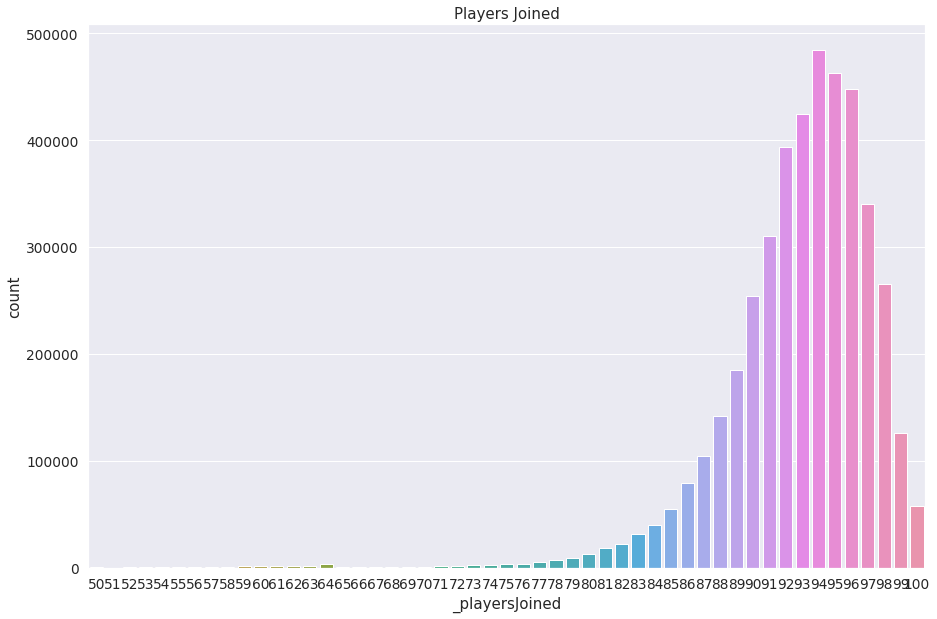

In [ ]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['_playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

There are a few matches with less than 75 players that cannot be displayed here. As you can see most of the matches are nearly packed and have almost 100 players. 

###Normalizing the features
Now that we have a feature '_playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:

- kills
- damageDealt
- maxPlace
- matchDuration

In [ ]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]


,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.68,1306,1384.36
1,eef90569b9d03c,0,0.00,91.470001,100.617001,26,28.60,1777,1954.70
2,1eaf90ac73de72,0,0.00,68.000000,72.760000,50,53.50,1318,1410.26
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.06,100.000000,106.000000,97,102.82,1424,1509.44
5,ff79c12f326506,1,1.09,100.000000,109.000000,28,30.52,1395,1520.55
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,9.221040,96,103.68,1967,2124.36
8,1a68204ccf9891,0,0.00,51.599998,54.179998,28,29.40,1375,1443.75
9,e5bb5a43587253,0,0.00,37.270000,40.251600,29,31.32,1930,2084.40


In [ ]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194


In [ ]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

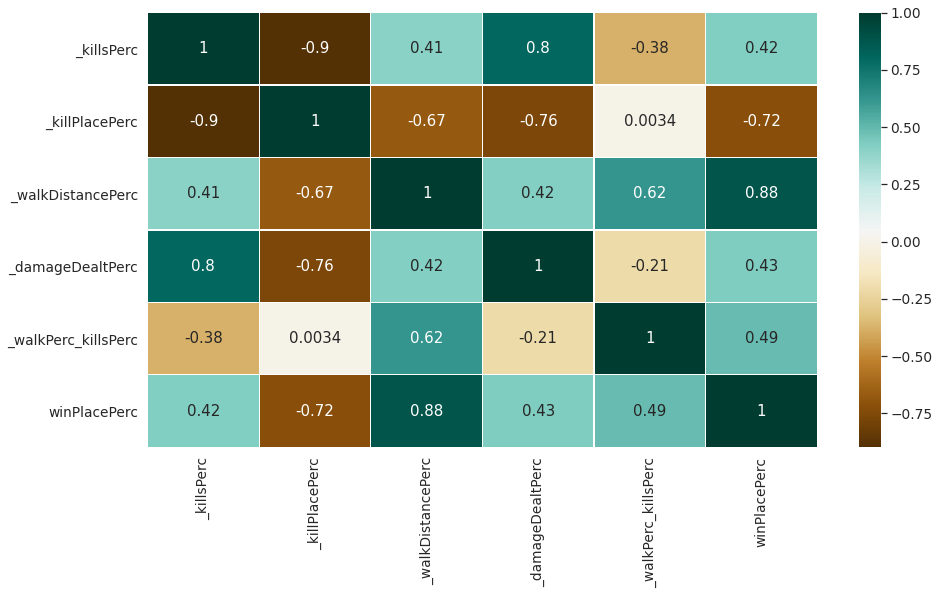

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [ ]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['_totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,NaN,2.142857,0.000000,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,NaN,2.192308,0.000000,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,NaN,0.940000,0.000000,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.0,0.463918,0.020101,0.020101,0.034937


In [ ]:
corr = cleaned_data[['killPlace', 'walkDistance','players_in_team','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()

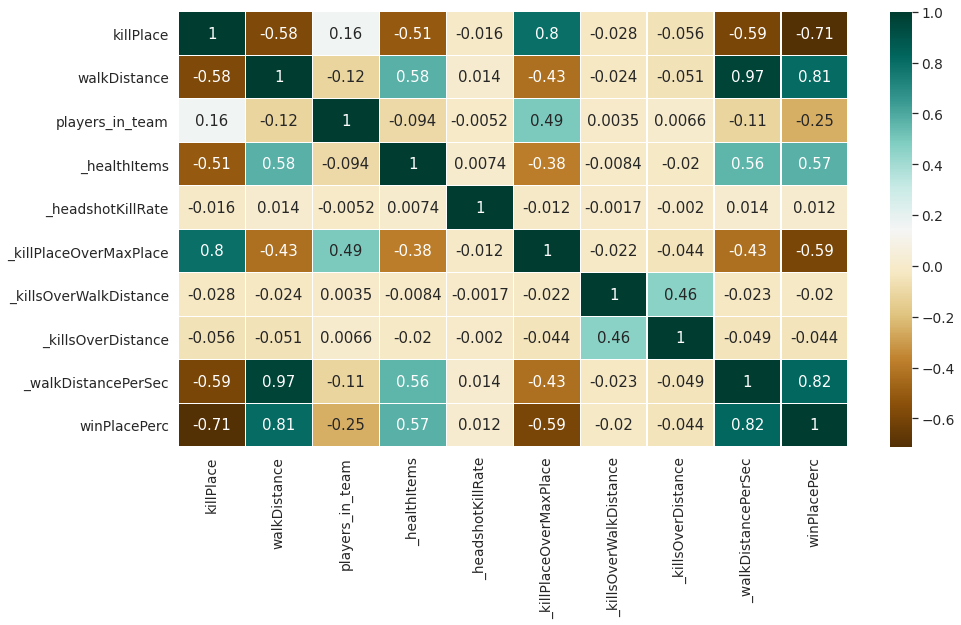

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [ ]:
cleaned_data.shape

(4349359, 49)

In [ ]:
cleaned_data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', '_totalDistance',
       '_headshot_rate', '_killsWithoutMoving', '_playersJoined', '_killsNorm',
       '_damageDealtNorm', '_maxPlaceNorm', '_matchDurationNorm', '_killsPerc',
       '_killPlacePerc', '_walkDistancePerc', '_damageDealtPerc',
       '_walkPerc_killsPerc', 'players_in_team', '_healthItems',
       '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance',
       '_killsOverDistance', '_walkDistancePerSec'],
      dtype='object')

In [ ]:
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [ ]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


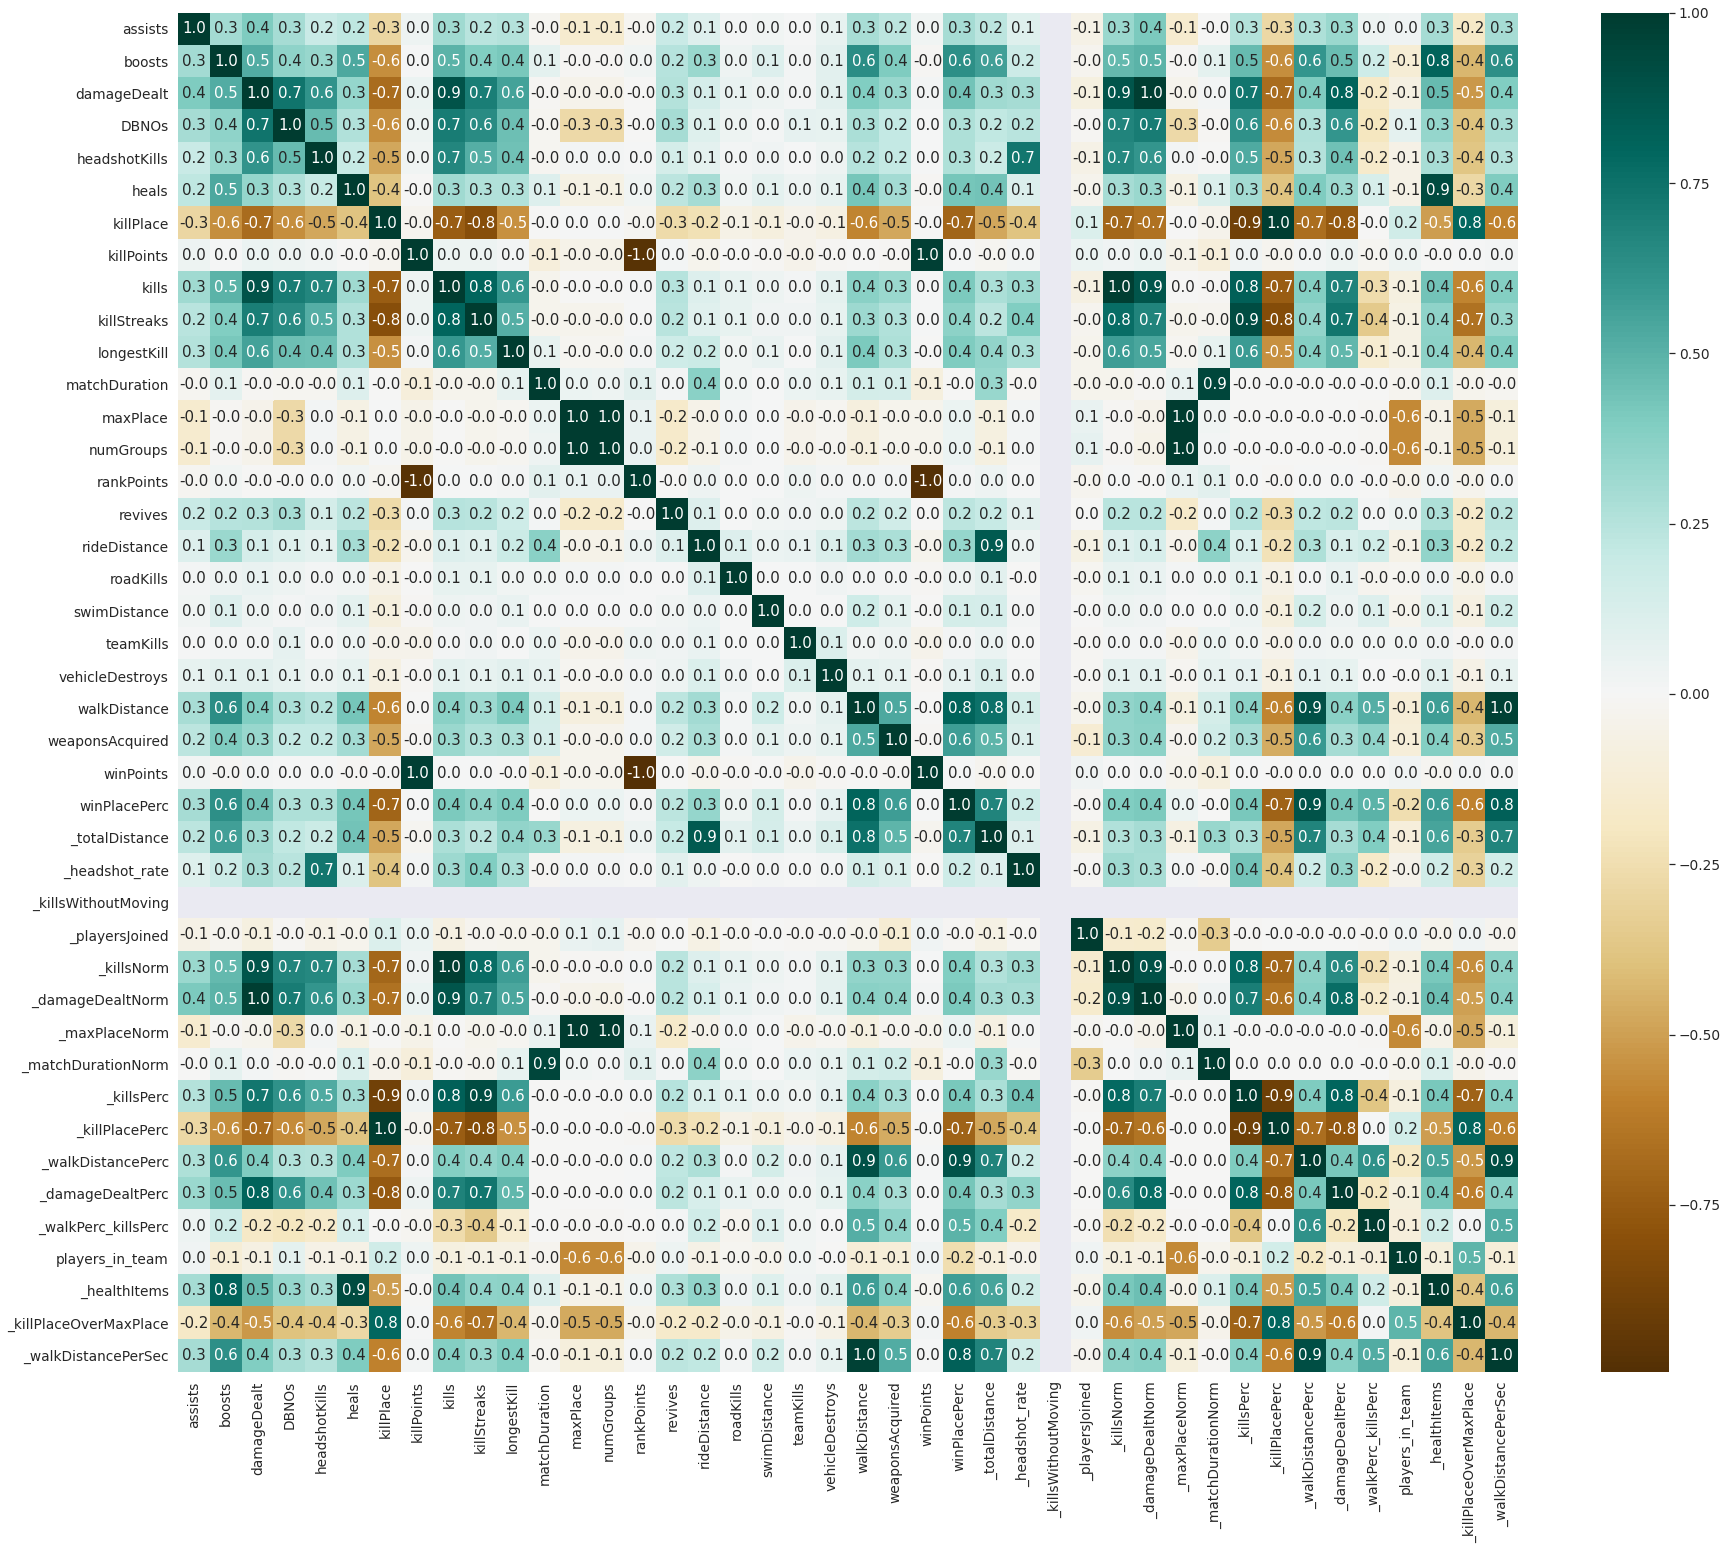

In [ ]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

##Removing features having 0 correlation with winPlacePerc

In [ ]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints', '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm', '_killsWithoutMoving'], axis=1, inplace=True)
# cleaned_data.drop(['headshotKills','roadKills','vehicleDestroys'], axis=1, inplace=True)
# cleaned_data.drop(['rideDistance','swimDistance'], axis=1, inplace=True)
# cleaned_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)


In [ ]:
# cleaned_data.drop(['maxPlace','numGroups','headshotKills','roadKills', 'teamKills','vehicleDestroys'], axis=1, inplace=True)

In [ ]:
# cleaned_data.drop(['_headshot_rate'], axis=1, inplace=True)

In [ ]:
cleaned_data.shape

##Removing variables with high correlation between them

In [ ]:
""" Remove all the variables having high correlation among them
Do it as a part of your assignment
"""

###Modifying the test data

In [ ]:
test.drop(['_playersJoined'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
test.shape

In [ ]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [ ]:
#saving highly correlated data
cleaned_data.to_csv(  '/content/Highly_correlated_data.csv', index=False)

#Part 4: Final Prediction

Let's have a look at our problem statement and our target variable

> **Problem Statement:** *You must create a model which predicts **players' finishing placement** based on their final stats, on a scale from 1 (first place) to 0 (last place)*

> **Target variable:** *winPlacePerc - This is a **percentile winning placement**, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.*

So our goal is to **rank** players and our target variable is a **percentile**. 

These two bits are critical pieces of information: the goal tells us what kind of **Machine Learning technique** we want to use and the target definition tells us about its **distribution**.

**Machine Learning Technique:** What is the metric?


Ideally, we would like to use a ranking algorithm like lambdarank/lambdamart.

Learning to Rank (LTR) is a class of techniques that apply supervised machine learning to solve ranking problems. Essentially, the ranking is transformed into a pairwise regression problem. The algorithm compares pairs of items and comes up with the optimal ordering for that pair, iterating through the different pairs to extrapolate with the final ranking of all items.

The business metric is the rank, not the MAE. Unfortunately, I've found the LGBM lambdarank implementation quite confusing and was unsuccessful at using it. As such we will optimize our algorithm using an MAE objective.

Limitations using MAE:
- The predictions are not bound, as such we can have some predictions falling above/below our percentile range
- The predictions are not going to be unique, you could have several players/teams assigned same scores


**Target variable:** Percentile

In a  game of PUBG, each team gets assigned a percentile value so there should approximatly be the same cout of 0s, 0.5s, 1s etc. (there might be irregularities in the distribution due imbalance in team sizes or number of teams). We should expect to see a uniform distribution for all percentile scores value, and a gaussian distribution with mean 0.5 for the average percentile score per match. We want our target to mimic a uniform distribution as much as possible.



In [ ]:
highly_corr = pd.read_csv('/content/Highly_correlated_data.csv')
highly_corr = reduce_mem_usage(highly_corr)

Memory usage of dataframe is 1128.22 MB --> 468.71 MB (Decreased by 58.5%)


In [ ]:
highly_corr.shape

In [ ]:
X_train = highly_corr[highly_corr['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = highly_corr[highly_corr['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)


Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId','Id'], axis=1, inplace=True)
X_test.drop(['matchId','groupId','Id'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(4349359, 30) (0, 30)


## Dealing with Categorical Variables

We will one hot encode the 'matchType' feature to use it in our Random Forest model.

In [ ]:
print('There are {} different Match types in the dataset.'.format(highly_corr['matchType'].nunique()))

In [ ]:
# One hot encode matchType
highly_corr = pd.get_dummies(highly_corr, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = highly_corr.filter(regex='matchType')
matchType_encoding.head()

,matchType_duo,matchType_solo,matchType_squad
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide.
We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

In [ ]:
# Turn groupId and match Id into categorical types
highly_corr['groupId'] = highly_corr['groupId'].astype('category')
highly_corr['matchId'] = highly_corr['matchId'].astype('category')

# Get category coding for groupId and matchID
highly_corr['groupId_cat'] = highly_corr['groupId'].cat.codes
highly_corr['matchId_cat'] = highly_corr['matchId'].cat.codes

# Get rid of old columns
highly_corr.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
highly_corr[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,609242,29996
1,821700,32654
2,837266,3131
3,1330566,45133
4,1744863,20468


In [ ]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
highly_corr.drop(columns = ['Id'], inplace=True)

# Getting prepared for Machine Learning <a id="8"></a>

## Sampling

We will take a sample of 500000 rows from our training set for easy debugging and exploration.

In [ ]:
# Take sample for debugging and exploration
sample = 500000
df_sample = highly_corr.sample(sample)

## Split target variable, validation data, etc.

In [ ]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [ ]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 34) Sample target shape:  (440000,) Sample validation shape:  (60000, 34)


## Defining function for calculating Mean Absolute Error (MAE)

In [ ]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Function to print the MAE (Mean Absolute Error) score

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    #Score of the training dataset obtained using an out-of-bag estimate.
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Creating a basic Random Forest Model

In [ ]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03099484656244668, 'mae val: ', 0.051514059666786176]


## Finding Feature Importance using Random Forest

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [ ]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:15]

,cols,imp
28,_walkDistancePerSec,0.203955
22,_walkDistancePerc,0.189899
14,walkDistance,0.113140
6,killPlace,0.102596
21,_killPlacePerc,0.102181
16,_totalDistance,0.080179
27,_killPlaceOverMaxPlace,0.031097
26,_healthItems,0.028845
24,_walkPerc_killsPerc,0.027402
1,boosts,0.019375


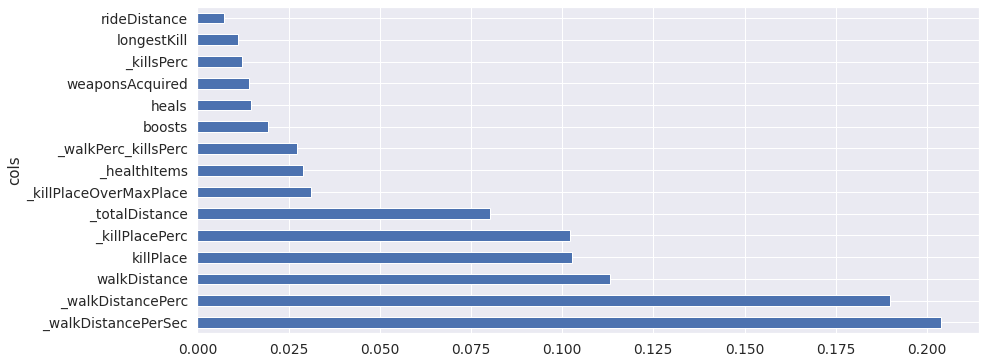

In [ ]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:15].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [ ]:
X_train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', '_totalDistance', '_headshot_rate', '_killsNorm',
       '_damageDealtNorm', '_killsPerc', '_killPlacePerc', '_walkDistancePerc',
       '_damageDealtPerc', '_walkPerc_killsPerc', 'players_in_team',
       '_healthItems', '_killPlaceOverMaxPlace', '_walkDistancePerSec',
       'matchType_duo', 'matchType_solo', 'matchType_squad', 'groupId_cat',
       'matchId_cat'],
      dtype='object')

In [ ]:
print(X_train.shape, y_train.shape)

(440000, 34) (440000,)


In [ ]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  17


28       _walkDistancePerSec
22         _walkDistancePerc
14              walkDistance
6                  killPlace
21            _killPlacePerc
16            _totalDistance
27    _killPlaceOverMaxPlace
26              _healthItems
24       _walkPerc_killsPerc
1                     boosts
5                      heals
15           weaponsAcquired
20                _killsPerc
9                longestKill
11              rideDistance
25           players_in_team
7                      kills
Name: cols, dtype: object

In [ ]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Building a Random Forest Model with top features

In [ ]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.02954028428365586, 'mae val: ', 0.049448066210607385]


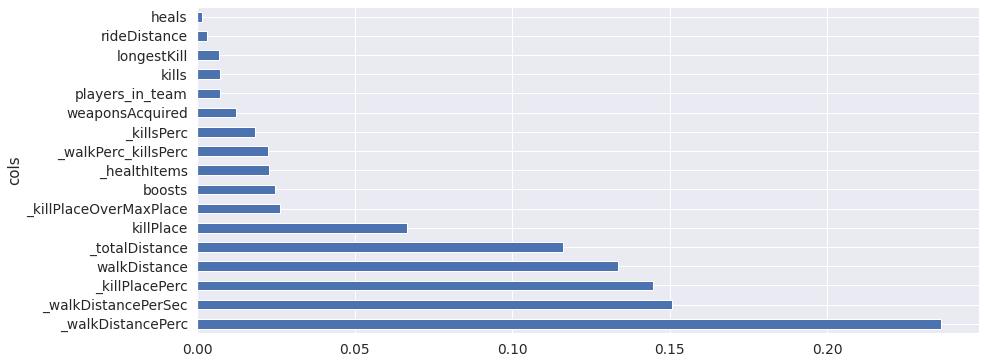

In [ ]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

###Generating a Dendogram to view highly correlated features

[]

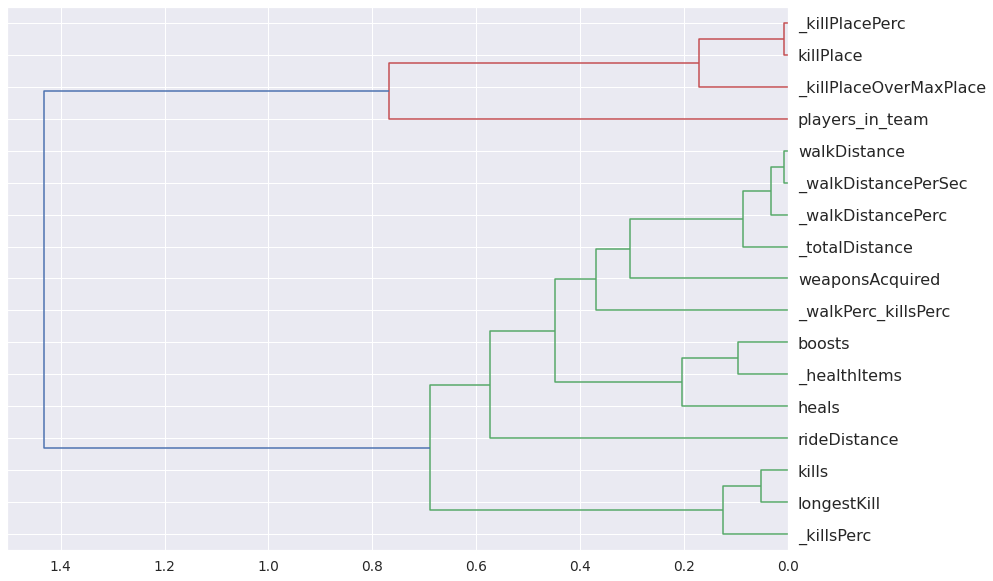

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [ ]:
# Defining a function get_sample to get random sample of n rows from dataframe(df), without replacement.
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 40 kB/s 
     |████████████████████████████████| 13.1 MB 52.0 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=e7da0a9152de63630186b349bc16059d483340f5d2269b88a00b7f1cbafb911b
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install pandas_summary

In [ ]:
!pip install plotnine

In [ ]:
df_keep.head()

,_walkDistancePerc,_totalDistance,_killPlacePerc,walkDistance,_walkDistancePerSec,killPlace,_killPlaceOverMaxPlace,_healthItems,boosts,weaponsAcquired,_walkPerc_killsPerc,_killsPerc,heals,_damageDealtNorm,rideDistance,damageDealt,longestKill,players_in_team,_killsNorm
2959446,0.557895,894.799988,0.042105,894.799988,0.476972,4,0.133333,11,2,4,0.569892,0.978947,9,852.390015,0.0,811.799988,30.950001,3,6.30
735967,0.166667,46.070000,0.822917,46.070000,0.033288,79,0.797980,0,0,1,0.653061,0.255208,0,0.000000,0.0,0.000000,0.000000,1,0.00
2418926,0.881579,2227.000000,0.236842,2227.000000,1.623178,18,0.222222,3,3,6,1.340000,0.657895,0,124.000000,0.0,100.000000,15.560000,1,1.24
222846,0.593407,5847.000000,0.120879,1837.000000,0.984459,11,0.392857,10,6,7,0.692308,0.857143,4,735.858948,4010.0,675.099976,171.300003,4,2.18
2201760,0.337209,274.500000,0.755814,274.500000,0.192092,65,1.413043,2,2,3,1.160000,0.290698,0,53.146797,0.0,46.619999,0.000000,2,0.00


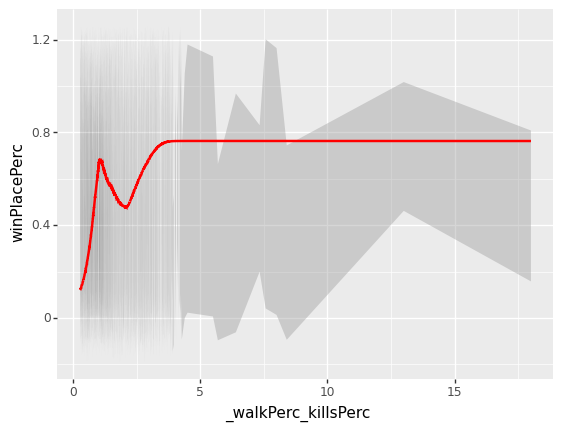

<ggplot: (8727902823912)>

In [ ]:
# Plot the predictive quality of kills 
# from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('_walkPerc_killsPerc','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

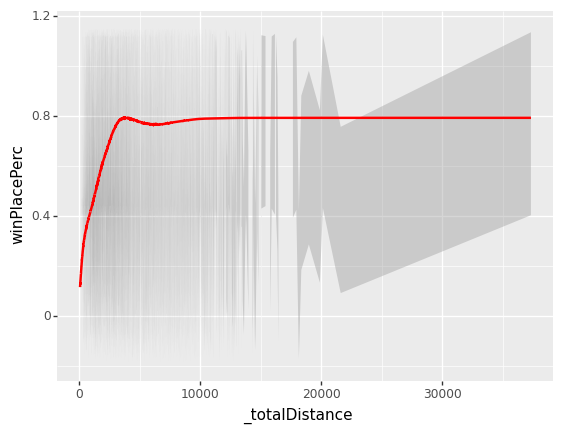

<ggplot: (-9223363308952128070)>

In [ ]:
# Plot the predictive quality of walkDistance
x_all = get_sample(highly_corr, 100000)
ggplot(x_all, aes('_totalDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

In [ ]:
# Prepare data
train = highly_corr.copy()
val_perc_full = 0.20 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

# Check dimensions of data
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3479488, 19) Sample target shape:  (3479488,) Sample validation shape:  (869871, 19)


In [ ]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.02546660676072762, 'mae val: ', 0.04704221408083837]


In [ ]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0


In [ ]:
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,_totalDistance,_headshot_rate,_killsNorm,_damageDealtNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec,matchType_duo,matchType_solo,matchType_squad,groupId_cat,matchId_cat
0,0,0,0.000000,0,0,0,60,0,0,0.000000,0,0.0000,0.00,0,244.800003,1,0.4444,244.800003,0.0,0.00,0.000000,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443,0,0,1,609242,29996
1,0,0,91.470001,0,0,0,57,0,0,0.000000,0,0.0045,11.04,0,1434.000000,5,0.6400,1445.044556,0.0,0.00,100.617004,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978,0,0,1,821700,32654
2,1,0,68.000000,0,0,0,47,0,0,0.000000,0,0.0000,0.00,0,161.800003,2,0.7755,161.800003,0.0,0.00,72.760002,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762,1,0,0,837266,3131
3,0,0,32.900002,0,0,0,75,0,0,0.000000,0,0.0000,0.00,0,202.699997,3,0.1667,202.699997,0.0,0.00,35.861000,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156,0,0,1,1330566,45133
4,0,0,100.000000,0,0,0,45,1,1,58.529999,0,0.0000,0.00,0,49.750000,2,0.1875,49.750000,0.0,1.06,106.000000,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937,0,1,0,1744863,20468


###Modifying the test data

In [ ]:
test = pd.read_csv('/content/test_V2.csv')
test = reduce_mem_usage(test)

Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


In [ ]:
#Adding same features to test data
agg = test.groupby(['groupId']).size().to_frame('players_in_team')
test = test.merge(agg, how='left', on=['groupId'])
test['_headshot_rate'] = test['headshotKills'] / test['kills']
test['_headshot_rate'] = test['_headshot_rate'].fillna(0)
test['_totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['_playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['_killsNorm'] = test['kills']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtNorm'] = test['damageDealt']*((100-test['_playersJoined'])/100 + 1)
test['_healthItems'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['_totalDistance'] == 0))
test['_killPlacePerc'] = test['killPlace'].rank(pct=True).values
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkPerc_killsPerc'] = test['_walkDistancePerc'] / test['_killsPerc']
test['_killPlaceOverMaxPlace'] = test['killPlace'] / test['maxPlace']
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkDistancePerSec'] = test['walkDistance'] / test['matchDuration']


In [ ]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,groupId_cat,matchId_cat,_headshot_rate,_totalDistance,_playersJoined,_killsNorm,_damageDealtNorm,_healthItems,killsWithoutMoving,_killPlacePerc,_killsPerc,_walkDistancePerc,_walkPerc_killsPerc,_killPlaceOverMaxPlace,players_in_team,_walkDistancePerSec
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,0,0,0,0.000000,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.000000,1,0,357523,5514,0.000000,588.000000,92,0.00,55.576799,0,False,0.766654,0.284210,0.475680,1.673695,2.607143,4,0.312102
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,0,2,1,361.899994,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.000000,6,0,231759,5268,0.000000,6686.000000,96,2.08,186.264006,6,False,0.111587,0.831127,0.758297,0.912373,0.229167,2,1.113749
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,0,0,0,0.000000,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.799988,4,0,39107,10783,0.000000,787.799988,94,0.00,24.804000,4,False,0.513972,0.284210,0.525046,1.847389,1.750000,4,0.439375
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,0,0,0,0.000000,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.000000,3,0,634157,2174,0.000000,1812.000000,89,0.00,72.727196,0,False,0.566769,0.284210,0.722077,2.540649,1.200000,2,0.988004
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,0,3,1,60.060001,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.000000,4,0,352749,5106,0.666667,2963.000000,95,3.15,346.710013,5,False,0.069081,0.910626,0.906597,0.995576,0.250000,3,2.234540


In [ ]:

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

In [ ]:
# # Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,_walkDistancePerc,_totalDistance,_killPlacePerc,walkDistance,_walkDistancePerSec,killPlace,_killPlaceOverMaxPlace,_healthItems,boosts,weaponsAcquired,_walkPerc_killsPerc,_killsPerc,heals,_damageDealtNorm,rideDistance,damageDealt,longestKill,players_in_team,_killsNorm
0,0.475680,588.000000,0.766654,588.000000,0.312102,73,2.607143,0,0,1,1.673695,0.284210,0,55.576799,0.0,51.459999,0.000000,4,0.00
1,0.758297,6686.000000,0.111587,2017.000000,1.113749,11,0.229167,6,4,6,0.912373,0.831127,2,186.264006,4669.0,179.100006,361.899994,2,2.08
2,0.525046,787.799988,0.513972,787.799988,0.439375,49,1.750000,4,0,4,1.847389,0.284210,4,24.804000,0.0,23.400000,0.000000,4,0.00
3,0.722077,1812.000000,0.566769,1812.000000,0.988004,54,1.200000,0,0,3,2.540649,0.284210,0,72.727196,0.0,65.519997,0.000000,2,0.00
4,0.906597,2963.000000,0.069081,2963.000000,2.234540,7,0.250000,5,4,4,0.995576,0.910626,1,346.710013,0.0,330.200012,60.060001,3,3.15


### Predicting the final winPlacePerc

In [ ]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})
pred_df
# Create submission file
# pred_df.to_csv("submission.csv", index=False)

,Id,winPlacePerc
0,9329eb41e215eb,0.271098
1,639bd0dcd7bda8,0.937192
2,63d5c8ef8dfe91,0.765491
3,cf5b81422591d1,0.632383
4,ee6a295187ba21,0.959230
...,...,...
1934169,a316c3a13887d5,0.797911
1934170,5312146b27d875,0.462261
1934171,fc8818b5b32ad3,0.911775
1934172,a0f91e35f8458f,0.831347
